In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import time

from joblib import Parallel, delayed, cpu_count
from matplotlib import cm

# Methods

In [2]:
def box(x,xlim):
    if x>max(xlim):
        return max(xlim)
    elif x<min(xlim):
        return min(xlim)
    else:
        return x

In [3]:
def h(x,y):
    return y-x

def g(x, y):
    return (y-2*x)**2

def dgx(x,y):
    return -4*(y-2*x)

def dgy(x,y):
    return 2*(y-2*x)

def dg(x,y):
    return np.array([dgx(x,y), dgy(x,y)])


def f(x,y):
    return np.exp(-y+2)/(2+np.cos(6*x))+0.5*np.log((4*x-2)**2+1)# + x**2

def f_np(x,y):
    return np.exp(-y+2)/(2+np.cos(6*x))+0.5*np.log((4*x-2)**2+1)# + x**2

def dfx(x,y):
    return 6*math.exp(-y+2)*math.sin(6*x)/((2+math.cos(6*x))**2)+(16*x-8)/((4*x-2)**2+1)# + 2*x

def dfy(x,y):
    return -math.exp(-y+2)/(2+math.cos(6*x))

def df(x,y):
    return np.array([dfx(x,y), dfy(x,y)])




In [4]:
def sflcb(x, y, z, alpha, beta, u, v, hparams,xlim,epsilon=0.01,max_iters=10000):

    eta_x = hparams['eta_x']
    eta_y = hparams['eta_x']
    eta_z = hparams['eta_x']
    eta_u = hparams['eta_x']
    eta_v = hparams['eta_x']
    delta = hparams['delta']
    rho_1 = hparams['rho_1']
    rho_2 = hparams['rho_2']
    t=0
    x=box(x,xlim)
    ys=[]
    zs=[]
    xs=[]
    dx=10000

    

    while t < max_iters:
        h_alpha=h(x,y)-alpha
        h_beta=h(x,z)-beta

        u=u+eta_u*(h_alpha)
        v=v+eta_v*(h_beta)
        dx=delta* dfx(x,y)+dgx(x,y)-dgx(x,z)-u+v - rho_1*h_alpha +rho_2*h_beta
        dy=delta* dfy(x,y)+dgy(x,y)+u + rho_1*h_alpha
        dz=-dgy(x,z)-v - rho_2*h_beta
        dalpha=-u -rho_1*h_alpha
        dbeta=v +rho_2*h_beta
        x=x-eta_x*dx

        x=box(x,xlim)
        
        y=y-eta_y*dy
        z=z+eta_z*dz
        alpha=alpha-eta_y*dalpha
        beta=beta+eta_z*dbeta
        alpha=np.minimum(alpha, 0)
        beta=np.minimum(beta, 0)
        t+=1
        xs.append(x)
        ys.append(y)
        zs.append(z)
    return x,y,z,t

    


In [5]:
def run_sflcb(epsilon=1e-6):

    x=np.random.uniform(0,3)
    y=np.random.uniform(-5,8.5)
    z=np.copy(y)
    alpha=h(x,y)
    beta=h(x,z)
    u = np.random.uniform(0, 10)
    v = np.copy(u)

    hparams = {
        'delta': 0.1,
        'eta_x': 0.01,
        'eta_y': 0.01,
        'eta_z': 0.01,
        'eta_u': 0.01,
        'eta_v': 0.01,
        'rho_1': 1,
        'rho_2': 1,
    }
    xlim = [0., 3.]

    

    t_start = time.time()
    x, y, z, k= sflcb(x, y, z, alpha, beta, u, v, hparams,xlim,epsilon=epsilon,max_iters=10000)
    t_elapsed = (time.time() - t_start)


    return x, y, z, k, t_elapsed

In [8]:


n_jobs = cpu_count()
N = 200
results = Parallel(n_jobs=n_jobs)(delayed(run_sflcb)() for i in range(N))

ps = np.array(results)

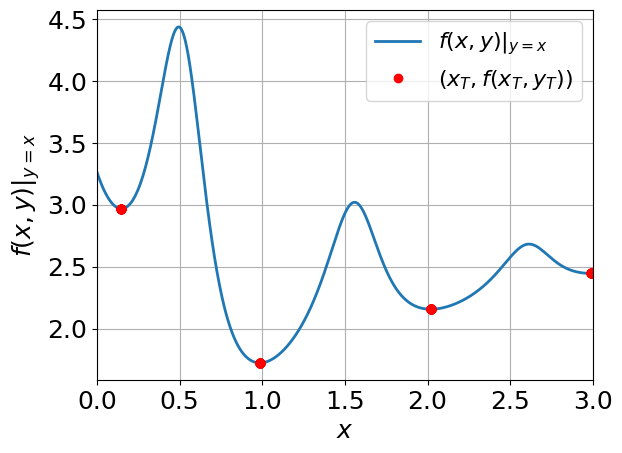

In [18]:
x_ax = np.linspace(0, 3, 1000)

#plt.figure(figsize=(6, 6))
plt.plot(x_ax, f_np(x_ax,x_ax), linewidth=2)
for i in range(N):
    plt.plot(ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r')

plt.legend(['$f(x,y)|_{y=x}$', '$(x_T, f(x_T,y_T))$'], fontsize=16)
plt.grid()
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$f(x,y)|_{y=x}$', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim([0,3])
plt.savefig('convergence.png')